# Azure Machine Learning
### How to use Python Notebooks in Azure

**In this lab, you will learn how to use Azure ML Python SDK to register, package and deploy a Machine Learning model to an Azure Container Instance as a scoring web service.**



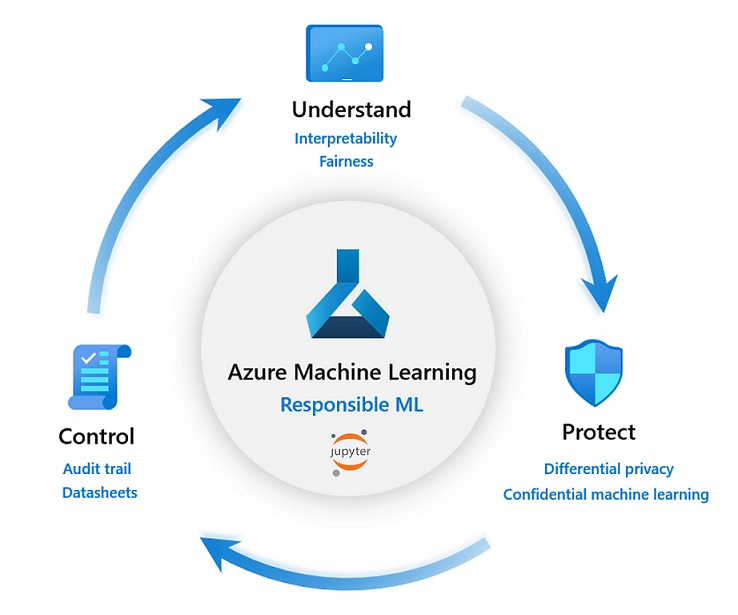

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Deployment of Automated Machine Learning Model

## Quick Start Overview

In this quickstart, you will start with a model that was trained using Automated Machine Learning. Learn how to use the Azure ML Python SDK to register, package, and deploy the trained model to Azure Container Instance as a scoring web service. Finally, test the deployed model (1) by make direct calls on service object, (2) by calling the service end point (Scoring URI) over http.

Because you will be using the Azure Machine Learning SDK, you will be able to provision all your required Azure resources directly from this notebook, without having to use the Azure Portal to create any resources.

### Setup
To begin, you will need to provide the following information about your Azure Subscription.

**If you are using your own Azure subscription, please provide names for subscription_id, resource_group, workspace_name and workspace_region to use.** Note that the workspace needs to be of type [Machine Learning Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/setup-create-workspace).

**If an environment is provided to you be sure to replace the values below with your unique identifier.**

In the following cell, be sure to set the values for `subscription_id`, `resource_group`, `workspace_name` and `workspace_region` as directed by the comments (*these values can be acquired from the Azure Portal*).

To get these values, do the following:
1. Navigate to the Azure Portal and login with the credentials provided.
2. From the left hand menu, under Favorites, select `Resource Groups`.
3. In the list, select the resource group with the name similar to `XXXXX`.
4. From the Overview tab, capture the desired values.

Execute the following cell by selecting the `>|Run` button in the command bar above.

In [3]:
#Provide the Subscription ID of your existing Azure subscription
subscription_id = "" # <- needs to be the subscription with the Quick-Starts resource group

#Provide values for the existing Resource Group
resource_group = "aml-tutorial-1" # <- replace with your unique identifier

#Provide the Workspace Name and Azure Region of the Azure Machine Learning Workspace
workspace_name = "MyMLWorkspace" # <- replace with your unique identifier
workspace_region = "EastUS2 " # <- region of your Quick-Starts resource group

### Download the model that was trained using Automated Machine Learning

In [4]:
import urllib.request
import os

model_folder = './automl-model'
model_file_name = 'model.pkl'
model_path = os.path.join(model_folder, model_file_name)

# this is the URL to download a model that was trained using Automated Machine Learning
model_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
             'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/'
             'quickstarts/automl-model/v2/model.pkl')

# Download the model to your local disk in the model_folder
os.makedirs(model_folder, exist_ok=True)
urllib.request.urlretrieve(model_url, model_path)

('./automl-model/model.pkl', <http.client.HTTPMessage at 0x7d95323a9750>)

### Import required packages

The Azure Machine Learning SDK provides a comprehensive set of a capabilities that you can use directly within a notebook including:
- Creating a **Workspace** that acts as the root object to organize all artifacts and resources used by Azure Machine Learning.
- Creating **Experiments** in your Workspace that capture versions of the trained model along with any desired model performance telemetry. Each time you train a model and evaluate its results, you can capture that run (model and telemetry) within an Experiment.
- Creating **Compute** resources that can be used to scale out model training, so that while your notebook may be running in a lightweight container in Azure Notebooks, your model training can actually occur on a powerful cluster that can provide large amounts of memory, CPU or GPU.
- Using **Automated Machine Learning (AutoML)** to automatically train multiple versions of a model using a mix of different ways to prepare the data and different algorithms and hyperparameters (algorithm settings) in search of the model that performs best according to a performance metric that you specify.
- Packaging a Docker **Image** that contains everything your trained model needs for scoring (prediction) in order to run as a web service.
- Deploying your Image to either Azure Kubernetes or Azure Container Instances, effectively hosting the **Web Service**.

In Azure Notebooks, all of the libraries needed for Azure Machine Learning are pre-installed. To use them, you just need to import them. Run the following cell to do so:

In [9]:
import azureml.core
from azureml.core import Workspace
from azureml.core.webservice import Webservice, AksWebservice
from azureml.core.image import Image
from azureml.core.model import Model

print("Azure ML SDK version:", azureml.core.VERSION)

Azure ML SDK version: 1.52.0


### Create and connect to an Azure Machine Learning Workspace

Run the following cell to create a new Azure Machine Learning **Workspace**.

**Important Note**: You will be prompted to login in the text that is output below the cell. Be sure to navigate to the URL displayed and enter the code that is provided. Once you have entered the code, return to this notebook and wait for the output to read `Workspace configuration succeeded`.

In [10]:
ws = Workspace.create(
    name = workspace_name,
    subscription_id = subscription_id,
    resource_group = resource_group,
    location = workspace_region,
    exist_ok = True)

ws.write_config()

print('Workspace configuration succeeded')

Performing interactive authentication. Please follow the instructions on the terminal.


KeyboardInterrupt: ignored

In [ ]:
# Display a summary of the current environment
import pandas as pd
output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

## Register Model

Azure Machine Learning provides a Model Registry that acts like a version controlled repository for each of your trained models. To version a model, you use  the SDK as follows. Run the following cell to register the best model with Azure Machine Learning.

In [ ]:
# register the model for deployment
model = Model.register(model_path = model_path, # this points to a local file
                       model_name = "nyc-taxi-automl-predictor", # name the model is registered as
                       tags = {'area': "auto", 'type': "regression"},
                       description = "NYC Taxi Fare Predictor",
                       workspace = ws)

print()
print("Model registered: {} \nModel Description: {} \nModel Version: {}".format(model.name,
                                                                                model.description, model.version))

## Deploy the Model as a Web Service

### Create the Scoring Script

Azure Machine Learning SDK gives you control over the logic of the web service, so that you can define how it retrieves the model and how the model is used for scoring. This is an important bit of flexibility. For example, you often have to prepare any input data before sending it to your model for scoring. You can define this data preparation logic (as well as the model loading approach) in the scoring file.

Run the following cell to create a scoring file that will be included in the Docker Image that contains your deployed web service.

**Important** Please update the `model_name` variable in the script below. The model name should be the same as the `Model registered` printed above.

In [ ]:
%%writefile scoring_service.py

import json
import numpy as np
import pandas as pd
import azureml.train.automl

columns = ['vendorID', 'passengerCount', 'tripDistance', 'hour_of_day', 'day_of_week', 'day_of_month',
           'month_num', 'normalizeHolidayName', 'isPaidTimeOff', 'snowDepth', 'precipTime',
           'precipDepth', 'temperature']

def init():
    try:
        # One-time initialization of predictive model and scaler
        from azureml.core.model import Model
        from sklearn.externals import joblib
        global model

        model_name = 'nyc-taxi-automl-predictor'
        print('Looking for model path for model: ', model_name)
        model_path = Model.get_model_path(model_name=model_name)
        print('Looking for model in: ', model_path)
        model = joblib.load(model_path)
        print('Model loaded...')

    except Exception as e:
        print('Exception during init: ', str(e))

def run(input_json):
    try:
        inputs = json.loads(input_json)
        data_df = pd.DataFrame(np.array(inputs).reshape(-1, len(columns)), columns = columns)
        # Get the predictions...
        prediction = model.predict(data_df)
        prediction = json.dumps(prediction.tolist())
    except Exception as e:
        prediction = str(e)
    return prediction

## Package Model

Run the next two cells to create the deployment **Image**

*WARNING: to install, build-essential needs to be available on the Docker image and is not by default. Thus, we will create a custom dockerfile with build-essential installed.*

In [ ]:
%%writefile dockerfile
RUN apt-get update && apt-get install -y build-essential

In [ ]:
conda_file = 'automl_dependencies.yml'
runtime = 'python'

# create container image configuration
print("Creating container image configuration...")
from azureml.core.image import ContainerImage
image_config = ContainerImage.image_configuration(execution_script = 'scoring_service.py',
                                                  runtime = runtime,
                                                  conda_file = conda_file,
                                                  docker_file = 'dockerfile')

# create the image
image_name = 'nyc-taxi-automl-image'

from azureml.core import Image
image = Image.create(name=image_name, models=[model], image_config=image_config, workspace=ws)

# wait for image creation to finish
image.wait_for_creation(show_output=True)

## Deploy Model to Azure Container Instance (ACI) as a Web Service

In [ ]:
from azureml.core.webservice import AciWebservice, Webservice

aci_name = 'aci-cluster'

aci_config = AciWebservice.deploy_configuration(
    cpu_cores = 1,
    memory_gb = 1,
    tags = {'name': aci_name},
    description = 'NYC Taxi Fare Predictor Web Service')

service_name = 'nyc-taxi-srv'

aci_service = Webservice.deploy_from_image(deployment_config=aci_config,
                                           image=image,
                                           name=service_name,
                                           workspace=ws)

aci_service.wait_for_deployment(show_output=True)

## Test the deployed web service

### Make direct calls on the service object

In [ ]:
import json

data1 = [1, 2, 5, 9, 4, 27, 5, 'Memorial Day', True, 0, 0.0, 0.0, 65]

data2 = [[1, 3, 10, 15, 4, 27, 7, 'None', False, 0, 2.0, 1.0, 80],
         [1, 2, 5, 9, 4, 27, 5, 'Memorial Day', True, 0, 0.0, 0.0, 65]]

result = aci_service.run(json.dumps(data1))
print('Predictions for data1')
print(result)

result = aci_service.run(json.dumps(data2))
print('Predictions for data2')
print(result)

### Challenge Task: Consume the Deployed Web Service

Complete the code below to consume the deployed webservice over HTTP

A complete solution can be found in the accompanying notebook: solution-deployment-with-AML.ipynb

In [ ]:
import requests

url = ...
print('ACI Service: {} scoring URI is: {}'.format(service_name, url))
headers = {'Content-Type':'application/json'}

# Create request to post test data1
response = ...
print('Predictions for data1')
print(response.text)

# Create request to post test data2
response = ...
print('Predictions for data2')
print(response.text)